<a href="https://colab.research.google.com/github/Israelamat/FER2013-Emotion-recognition-project-/blob/main/FER2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descargar dataset FER2013 desde Archive.org
!wget https://archive.org/download/fer2013_202311/fer2013.csv

# Cargar el CSV con pandas
import pandas as pd
df = pd.read_csv("fer2013.csv")

# Comprobar carga
print("Dataset cargado. Tamaño:", df.shape)
print(df.head())


--2025-06-20 14:37:40--  https://archive.org/download/fer2013_202311/fer2013.csv
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600507.us.archive.org/35/items/fer2013_202311/fer2013.csv [following]
--2025-06-20 14:37:42--  https://ia600507.us.archive.org/35/items/fer2013_202311/fer2013.csv
Resolving ia600507.us.archive.org (ia600507.us.archive.org)... 207.241.227.187
Connecting to ia600507.us.archive.org (ia600507.us.archive.org)|207.241.227.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301072766 (287M) [text/csv]
Saving to: ‘fer2013.csv’

fer2013.csv         100%[===================>] 287.12M  63.1MB/s    in 5.1s    

2025-06-20 14:37:48 (56.5 MB/s) - ‘fer2013.csv’ saved [301072766/301072766]

Dataset cargado. Tamaño: (35887, 3)
   emotion                                             pixels     Usage
0      

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow import config
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
# Convertir pixeles a arrays
pixels = df['pixels'].str.split().tolist()
X = np.array(pixels, dtype='float32').reshape(-1, 48, 48, 1) / 255.0

# Etiquetas y codificación one-hot
y = to_categorical(df['emotion'], num_classes=7)

# Separar según Usage
train_idx = df['Usage'] == 'Training'
val_idx = df['Usage'] == 'PublicTest'
test_idx = df['Usage'] == 'PrivateTest'

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]
X_test, y_test   = X[test_idx], y[test_idx]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (28709, 48, 48, 1) (28709, 7)
Val: (3589, 48, 48, 1) (3589, 7)
Test: (3589, 48, 48, 1) (3589, 7)


In [ ]:
def build_light_cnn():
    input_img = Input(shape=(48, 48, 1))

    x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.4)(x)
    output = Dense(7, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    return model

# Crear y compilar modelo
model = build_light_cnn()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para detener temprano y guardar el mejor modelo
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ModelCheckpoint("best_fer_lightcnn.h5", save_best_only=True)
]

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2675 - loss: 1.8389

225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.2680 - loss: 1.8378 - val_accuracy: 0.2494 - val_loss: 2.5971
Epoch 2/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4289 - loss: 1.4988

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.4291 - loss: 1.4985 - val_accuracy: 0.2271 - val_loss: 2.4902
Epoch 3/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4878 - loss: 1.3577

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.4879 - loss: 1.3575 - val_accuracy: 0.3931 - val_loss: 1.6158
Epoch 4/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5204 - loss: 1.2780

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.5204 - loss: 1.2780 - val_accuracy: 0.4631 - val_loss: 1.4686
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.5443 - loss: 1.2205 - val_accuracy: 0.3625 - val_loss: 1.6281
Epoch 6/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5664 - loss: 1.1698

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.5663 - loss: 1.1698 - val_accuracy: 0.5174 - val_loss: 1.2717
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.5811 - loss: 1.1306 - val_accuracy: 0.4288 - val_loss: 1.5856
Epoch 8/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5855 - loss: 1.1121

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.5856 - loss: 1.1120 - val_accuracy: 0.5598 - val_loss: 1.2014
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.6019 - loss: 1.0669 - val_accuracy: 0.4614 - val_loss: 1.4661
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.6150 - loss: 1.0380 - val_accuracy: 0.5274 - val_loss: 1.2443
Epoch 11/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6298 - loss: 0.9996

225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.6298 - loss: 0.9997 - val_accuracy: 0.5525 - val_loss: 1.1774
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.6396 - loss: 0.9740 - val_accuracy: 0.4831 - val_loss: 1.4214
Epoch 13/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6443 - loss: 0.9611

225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.6444 - loss: 0.9611 - val_accuracy: 0.5762 - val_loss: 1.1655
Epoch 14/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.6677 - loss: 0.9056 - val_accuracy: 0.5670 - val_loss: 1.1782
Epoch 15/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.6710 - loss: 0.8896 - val_accuracy: 0.5676 - val_loss: 1.1717
Epoch 16/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.6890 - loss: 0.8590 - val_accuracy: 0.5397 - val_loss: 1.2835
Epoch 17/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - accuracy: 0.6948 - loss: 0.8419 - val_accuracy: 0.5776 - val_loss: 1.2086
Epoch 18/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.7017 - loss: 0.8037 - val_accuracy: 0.5628 - val_loss: 1.2139
Epoch 19/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.7115 - loss: 0.7909 - val_accuracy: 0.5743 - val_loss: 1.2068
Epoch 20/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.7263 - loss: 0.756

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5580 - loss: 1.1746

🎯 Precisión en test: 0.5642


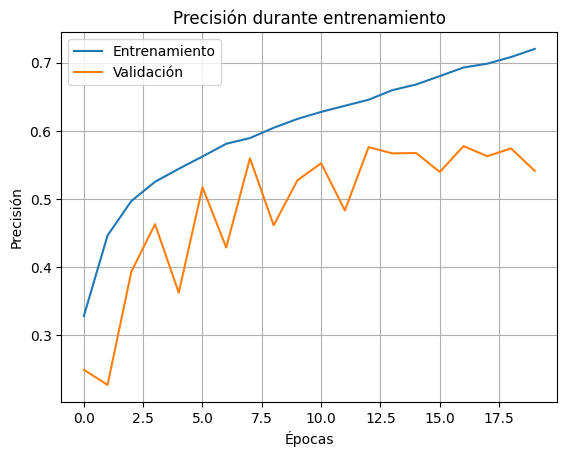

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Precisión en test: {test_acc:.4f}")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Precisión en test: {test_acc:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5580 - loss: 1.1746

🎯 Precisión en test: 0.5642
